In [99]:
import sys
import os
import numpy as np
import cv2 as cv
import pandas as pd
import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw

In [100]:
train = pd.read_csv("data/annotations/annotations.csv")
train.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,Resistor,269,399,41,47,11M_1-2W_(8).jpg,700,700
1,Wire,297,460,24,43,11M_1-2W_(8).jpg,700,700
2,Wire,269,358,17,30,11M_1-2W_(8).jpg,700,700
3,Brown,278,402,12,5,11M_1-2W_(8).jpg,700,700
4,Brown,280,410,12,5,11M_1-2W_(8).jpg,700,700


In [101]:
coords = train[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].copy()
coords.columns = ['x1', 'y1', 'w', 'h']
coords.head()

,x1,y1,w,h
0,269,399,41,47
1,297,460,24,43
2,269,358,17,30
3,278,402,12,5
4,280,410,12,5


In [102]:
df = pd.concat([train, coords], axis = 1)

In [103]:
df["x1"] = pd.to_numeric(df["x1"])
df["y1"] = pd.to_numeric(df["y1"])
df["w"] = pd.to_numeric(df["w"])
df["h"] = pd.to_numeric(df["h"])

In [104]:
df["x2"] = df["x1"] + df["w"]
df["y2"] = df["y1"] + df["h"]

In [105]:
df.drop(['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'image_width', 'image_height', 'w', 'h', 'label_name'], axis = 1, inplace = True)
df.head()

,image_name,x1,y1,x2,y2
0,11M_1-2W_(8).jpg,269,399,310,446
1,11M_1-2W_(8).jpg,297,460,321,503
2,11M_1-2W_(8).jpg,269,358,286,388
3,11M_1-2W_(8).jpg,278,402,290,407
4,11M_1-2W_(8).jpg,280,410,292,415


In [106]:
unique_imgs = df["image_name"].unique()

unique_test_imgs = [
  "11M_1-2W_(10).jpg",
  "11M_1-2W_(11).jpg",
]

print(unique_imgs, len(unique_imgs))

['11M_1-2W_(8).jpg' '11M_1-2W_(9).jpg' 'IMG_5124.JPG'] 3


In [107]:
class TrainDataset(torch.utils.data.Dataset):
  def __init__(self, df, unique_imgs, indices, img_dir):
    self.df = df
    self.unique_imgs = unique_imgs
    self.indices = indices
    self.img_dir = img_dir
  def __len__(self):
    return len(self.indices)
  def __getitem__(self, idx):
    image_name = self.unique_imgs[self.indices[idx]]
    boxes = self.df[self.df.image_name == image_name].values[:, 1:].astype("float")
    img = Image.open(os.path.join(self.img_dir, image_name)).convert("RGB")
    labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
    target = {}
    target['boxes'] = torch.tensor(boxes)
    target['labels'] = labels
    return T.ToTensor()(img), target

In [108]:
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, img_dir):
    self.img_dir = img_dir
    self.image_names = os.listdir(img_dir)

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    image_name = self.image_names[idx]
    img = Image.open(os.path.join(self.img_dir, image_name)).convert("RGB")
    return T.ToTensor()(img), image_name

In [109]:
def train_val_test_split(unique_imgs, val_size=0.2, test_size=0.1):
    """
    Split the dataset into training, validation, and test sets.

    Args:
        unique_imgs (list or array): List of unique images.
        val_size (float): Proportion of the dataset to include in the validation set.
        test_size (float): Proportion of the dataset to include in the test set.

    Returns:
        train_inds (list): Indices for the training set.
        val_inds (list): Indices for the validation set.
        test_inds (list): Indices for the test set.
    """
    assert 0 <= val_size + test_size < 1, "Validation and test sizes should not exceed 1.0"
    
    indices = np.arange(len(unique_imgs))
    np.random.shuffle(indices)

    test_split = round(len(indices) * test_size)
    val_split = round(len(indices) * val_size)
    
    if test_split == 0 and val_split > 0:
        test_split += 1
        val_split -= 1

    train_split = len(indices) - val_split - test_split

    train_inds = indices[:train_split]
    val_inds = indices[train_split:train_split+val_split]
    test_inds = indices[train_split+val_split:]

    return train_inds, val_inds, test_inds

In [124]:
train_inds, val_inds, test_inds = train_val_test_split(range(unique_imgs.shape[0]), val_size=1/3, test_size=0.1)

print(len(train_inds), len(val_inds), len(test_inds))
print("Train Indices:", train_inds)
print("Validation Indices:", val_inds)
print("Test Indices:", test_inds)


2 0 1
Train Indices: [1 2]
Validation Indices: []
Test Indices: [0]


In [125]:
def custom_collate(data):
  return data

In [126]:
train_dir = "data/train/"
val_dir = "data/train/"
test_dir = "data/test/"

train_dl = torch.utils.data.DataLoader(TrainDataset(df, unique_imgs, train_inds, train_dir), 
                              batch_size = 16, 
                              shuffle = True, 
                              collate_fn = custom_collate, 
                              pin_memory = True if torch.cuda.is_available() else False)

# val_dl = torch.utils.data.DataLoader(TrainDataset(df, unique_imgs, val_inds, val_dir),
#                               batch_size = 8,
#                               shuffle = True,
#                               collate_fn = custom_collate,
#                               pin_memory = True if torch.cuda.is_available() else False)


test_dl = torch.utils.data.DataLoader(TestDataset(test_dir), 
                                batch_size = 8, 
                                shuffle = False)


In [127]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 15 # Resistor, Wire, Color Bands + 1(Background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/Users/rohansagar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rohansagar/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [128]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [129]:
optimizer = torch.optim.SGD(model.parameters(), 
                    lr = 0.001,
                    momentum = 0.9, 
                    weight_decay = 0.0005)
num_epochs = 5

In [130]:
model.to(device)
for epochs in range(num_epochs):
  epoch_loss = 0
  for data in train_dl:
    imgs = []
    targets = []
    for d in data:
      imgs.append(d[0].to(device))
      targ = {}
      targ['boxes'] = d[1]['boxes'].to(device)
      targ['labels'] = d[1]['labels'].to(device)
      targets.append(targ)
    loss_dict = model(imgs, targets)
    loss = sum(v for v in loss_dict.values())
    epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("Epoch: {}, Loss: {}".format(epochs, epoch_loss))

Epoch: 0, Loss: 8.703472744852803
Epoch: 1, Loss: 4.076966283507493
Epoch: 2, Loss: 2.920168777867956
Epoch: 3, Loss: 2.3696018373679237
Epoch: 4, Loss: 1.8593327214337085


In [146]:
# model.eval()
# data = iter(train_dl).__next__()

model.eval()
data = iter(test_dl).__next__()

In [147]:
# img = data[0][0]
# boxes = data[0][1]['boxes']
# labels = data[0][1]['labels']

img = data[0][0].to(device)
image_name = data[1][0]
image_name

'11M_1-2W_(10).jpg'

In [148]:
output = model([img.to(device)])
output

# with torch.no_grad():
#   output = model([img.to(device)])

# print(output[0]["labels"], output[0]["scores"])

# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# image_np = img.cpu().numpy().transpose(1,2,0)

# fig, ax = plt.subplots(1, figsize=(12, 9))
# ax.imshow(image_np)

# for box in output[0]['boxes']:
#     rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

# plt.show()

[{'boxes': tensor([[312.5401, 313.7932, 332.8949, 328.9006],
          [310.3421, 314.0244, 355.7388, 361.0358],
          [315.5599, 324.2862, 347.0195, 358.7048],
          [337.0856, 341.7240, 354.4665, 356.9236],
          [312.2465, 309.2342, 331.9362, 323.2808]], grad_fn=<StackBackward0>),
  'labels': tensor([ 8,  8, 12,  8,  8]),
  'scores': tensor([0.0627, 0.0621, 0.0596, 0.0554, 0.0504], grad_fn=<IndexBackward0>)}]

In [149]:
out_bbox = output[0]["boxes"]
out_label = output[0]["labels"]
out_scores = output[0]["scores"] 
print("out_box", out_bbox, "out_scores", out_scores)

out_box tensor([[312.5401, 313.7932, 332.8949, 328.9006],
        [310.3421, 314.0244, 355.7388, 361.0358],
        [315.5599, 324.2862, 347.0195, 358.7048],
        [337.0856, 341.7240, 354.4665, 356.9236],
        [312.2465, 309.2342, 331.9362, 323.2808]], grad_fn=<StackBackward0>) out_scores tensor([0.0627, 0.0621, 0.0596, 0.0554, 0.0504], grad_fn=<IndexBackward0>)


In [150]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [151]:
out_bbox.shape, keep.shape

(torch.Size([5, 4]), torch.Size([3]))

In [152]:
im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype("uint8")

In [153]:
im

array([[[155, 138, 128],
        [155, 138, 130],
        [153, 139, 130],
        ...,
        [139, 103,  81],
        [147, 110,  84],
        [143, 103,  78]],

       [[139, 122, 115],
        [140, 125, 118],
        [144, 129, 122],
        ...,
        [137,  99,  78],
        [146, 106,  81],
        [144, 102,  78]],

       [[145, 131, 128],
        [146, 132, 129],
        [148, 134, 131],
        ...,
        [141,  98,  79],
        [147, 102,  79],
        [142,  97,  74]],

       ...,

       [[142, 123, 116],
        [138, 119, 112],
        [137, 118, 111],
        ...,
        [148,  99,  82],
        [146,  97,  80],
        [147, 100,  72]],

       [[134, 111, 105],
        [134, 111, 105],
        [135, 112, 106],
        ...,
        [152,  97,  77],
        [150,  95,  75],
        [151,  98,  67]],

       [[132, 109, 103],
        [135, 112, 106],
        [137, 114, 108],
        ...,
        [152,  96,  73],
        [150,  94,  71],
        [149,  95,  61]]

In [154]:
vsample = Image.fromarray(im)

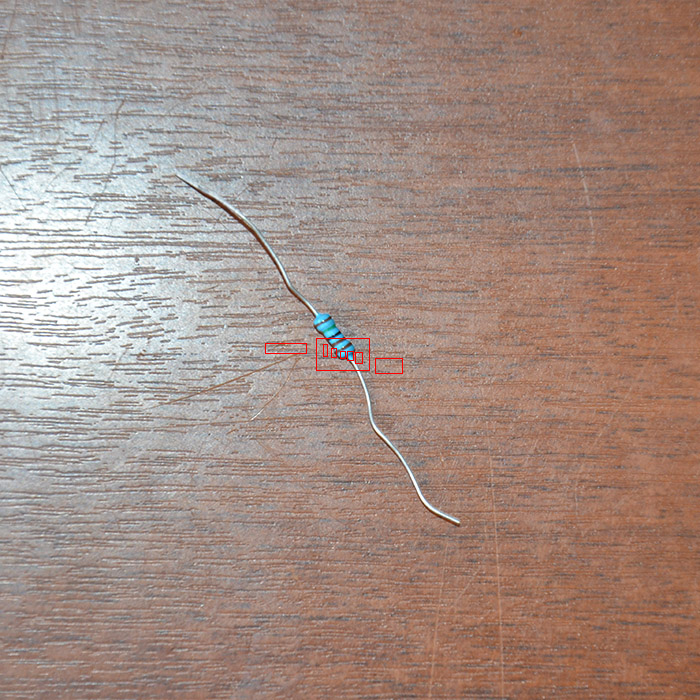

In [155]:
draw = ImageDraw.Draw(vsample)
for box in boxes:
  draw.rectangle(list(box), fill = None, outline = "red")
vsample